In [1]:
import sys, os, importlib
from IPython.display import Image

In [2]:
sys.path.append(os.path.abspath('../'))

In [3]:
from wmhpypes.interfaces import ibbmTum
from wmhpypes.workflows import ibbmTum_wf
from wmhpypes.interfaces import cat12

In [4]:
from nipype import (DataGrabber, 
                    DataSink, 
                    IdentityInterface, 
                    MapNode, 
                    Workflow, 
                    Node)

In [5]:
from nipype.interfaces import fsl
from nipype.interfaces import spm
from nipype.algorithms.misc import Gunzip

In [6]:
train_sublist = [i for i in os.listdir('/data/ag-wirth/User/2019_GaubertM/DELCODE_projects/dataset_2021_N50/WMH_segmentations/preprocessed_data/final_datasets/dataset_training_N20')]
train_sublist

['040356085',
 '1230b7af2',
 '16437ed4f',
 '1b349d5ca',
 '2d6cec24d',
 '312c25423',
 '4240c00eb',
 '428978e36',
 '437b2791f',
 '682305c91',
 '74891bf1b',
 '7cb61db43',
 '9ff13e297',
 'b46cebb5e',
 'b81ae1818',
 'bbb5dedd3',
 'ca8cd6a27',
 'e1c4b0748',
 'ec6ef4467',
 'fc3c650cd']

In [7]:
data_source = Node(interface=IdentityInterface(fields=['flairs', 'wmh']),
                   name='data_source')
data_source.inputs.flairs = ['/data/ag-wirth/User/2021_DellOrcoA/DELCODE/final_datasets/dataset_training_N20/{0}/flair_{0}M0_T1_01_1.nii.gz'.format(i) for i in train_sublist]
data_source.inputs.wmhs = ['/data/ag-wirth/User/2021_DellOrcoA/DELCODE/final_datasets/dataset_training_N20/{0}/segflair_{0}M0_manual.nii.gz'.format(i) for i in train_sublist]

In [8]:
# Preprocessing FLAIRS

bet = MapNode(interface=fsl.BET(reduce_bias=True,
                             frac=.2,
                             output_type='NIFTI'),
              iterfield=['in_file'],
              name='bet')
denoising = MapNode(interface=cat12.CAT12SANLMDenoising(),
                    iterfield=['in_files'],
                    name='denoising')

In [9]:
train_preproc = MapNode(interface=ibbmTum.Preprocessing(rows_standard=192, 
                                                        cols_standard=192,
                                                        thres=10),
                        iterfield = 'flair',
                        name='train_preproc')


In [10]:
flair_preproc = Workflow(name='flair_prep', base_dir='flair_prep')
flair_preproc.connect(bet, 'out_file', denoising, 'in_files')
flair_preproc.connect(denoising, 'out_file', train_preproc, 'flair')

In [11]:
wmh_train_preproc = MapNode(interface=ibbmTum.Preprocessing(rows_standard=192, 
                                                        cols_standard=192,
                                                        thres=10),
                        iterfield = 'flair',
                        name='wmh_train_preproc')

In [12]:
train = Node(interface=ibbmTum.Train(model_path='models',
                                    image_shape=(192,192,1)), name='train')

In [13]:
train_wf = Workflow(name='train_wf', base_dir='train_wf')
train_wf.connect(data_source, 'flairs', flair_preproc, 'bet.in_file')
train_wf.connect(data_source, 'wmhs', wmh_train_preproc, 'flair')
train_wf.connect(flair_preproc, 'train_preproc.preprocessed_array', train, 'images')
#train_wf.connect(flair_preproc, 'train_preproc.slice_shape', train, 'slice_shape')
train_wf.connect(wmh_train_preproc, 'preprocessed_array', train, 'masks')

In [14]:
sink = Node(interface=DataSink(), name = 'sink')
sink.inputs.base_directory = os.path.abspath('./out')
train_wf.connect(train, 'weights', sink, 'model.@weights')

210925-14:34:30,607 nipype.workflow INFO:
	 Generated workflow graph: ./imgs/train_wf.png (graph2use=colored, simple_form=True).


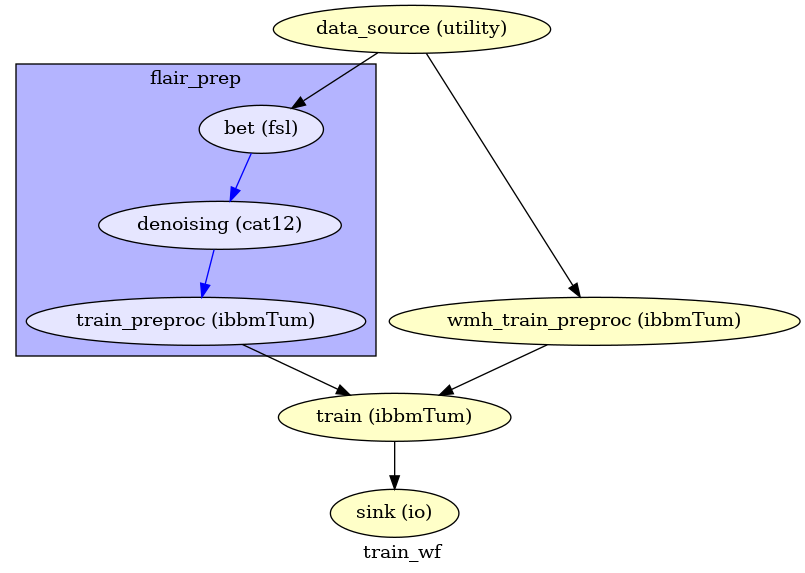

In [15]:
train_wf.write_graph(graph2use='colored', dotfilename='./imgs/train_wf.dot')
Image('./imgs/train_wf.png')

In [16]:
!uptime

 14:34:30 up 7 days, 19:38,  1 user,  load average: 2,08, 6,55, 4,06


In [17]:
#train_wf.run(plugin='MultiProc', plugin_args={'n_procs' : 30})
train_wf.run()

210925-14:34:30,816 nipype.workflow INFO:
	 Workflow train_wf settings: ['check', 'execution', 'logging', 'monitoring']
210925-14:34:30,843 nipype.workflow INFO:
	 Running serially.
210925-14:34:30,845 nipype.workflow INFO:
	 [Node] Setting-up "train_wf.flair_prep.bet" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/train_wf/flair_prep/bet".
210925-14:34:30,865 nipype.workflow INFO:
	 [Node] "train_wf.flair_prep.bet" found cached.
210925-14:34:30,867 nipype.workflow INFO:
	 [Node] Setting-up "train_wf.flair_prep.denoising" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/train_wf/flair_prep/denoising".
210925-14:34:30,894 nipype.workflow INFO:
	 [Node] "train_wf.flair_prep.denoising" found cached.
210925-14:34:30,896 nipype.workflow INFO:
	 [Node] Setting-up "train_wf.flair_prep.train_preproc" in

RuntimeError: Workflow did not execute cleanly. Check log for details

In [19]:
test_sublist = os.listdir('/data/ag-wirth/User/2021_DellOrcoA/DELCODE/final_datasets/dataset_test_N30')
test_sublist

['01dc83c85',
 'fd225d1ef',
 '34f06b217',
 '72e485c23',
 '3d0f5ce2b',
 '74c764c7b',
 '0a8d02f2b',
 'bc177df98',
 'c276f7df7',
 '8740df278',
 '13b9c5985',
 '9446d0c1d',
 '4798dd03c',
 '4a1bb1546',
 'd23ebb73d',
 '13c6322ae',
 '96357826f',
 '144014f58',
 '59d4008a7',
 '9dc5af14f',
 '5c4e89915',
 '60087d2cb',
 'ae818e1d7',
 'f2a767eaa',
 '172ff8939',
 '3037ab030',
 '60a8dd7f5',
 'f3a9124c6',
 'b362efb8f',
 'b38c31704']

In [20]:
from wmhpypes.interfaces import cat12
from wmhpypes.interfaces import misc
from nipype.interfaces import fsl

In [23]:

bet = Node(interface=fsl.BET(reduce_bias=True,
                             frac=.2,
                             output_type='NIFTI'), name='bet')
denoising = Node(interface=cat12.CAT12SANLMDenoising(), name='denoising')

In [25]:
from wmhpypes.workflows import ibbmTum_wf
test_wf = ibbmTum_wf.get_test_wf(row_st=192,
                                     cols_st=192,
                                     thres_mask=10)

In [27]:
data_source = Node(interface=IdentityInterface(fields = ['weights', 'sub-id']), name='data_source')
data_source.iterables = ('sub-id', test_sublist)
data_source.inputs.weights = [os.path.join(os.getcwd(), './models_newtrain', i) for i in os.listdir('./models_newtrain')]

In [34]:
data_grabber = Node(interface=DataGrabber(infields=['sub-id'],
                                          outfields=['flair']), name='data_grabber')
data_grabber.inputs.base_directory = '/data/ag-wirth/User/2021_DellOrcoA/DELCODE/final_datasets/dataset_test_N30'
data_grabber.inputs.template = '%s/flair_%sM0_T1_01_1.nii.gz'
data_grabber.inputs.template_args = {'flair' : [['sub-id', 'sub-id']]}
data_grabber.inputs.sort_filelist = False

In [36]:
delcode = Workflow(name='delcode', base_dir='./train_wf')
delcode.connect(bet, 'out_file', denoising, 'in_files')
delcode.connect(data_source, 'sub-id', data_grabber, 'sub-id')
delcode.connect(data_grabber, 'flair', bet, 'in_file')
delcode.connect(denoising, 'out_file', test_wf, 'inputspec.flair')
delcode.connect(data_source, 'weights', test_wf, 'inputspec.weights')

In [37]:
save_nii = Node(interface=misc.SaveNIfTI(), name='save_nii')
sink = Node(interface=DataSink(), name = 'sink')
sink.inputs.base_directory = os.path.abspath('./out')

In [38]:
delcode.connect(test_wf, 'outputspec.wmh_mask', save_nii, 'in_array') 
delcode.connect(data_grabber, 'flair', save_nii, 'in_header')
delcode.connect(data_grabber, 'flair', save_nii, 'in_matrix')                
delcode.connect(save_nii, 'out_file', sink, '@wmh_mask')

210925-17:47:40,945 nipype.workflow INFO:
	 Generated workflow graph: ./imgs/delcode.png (graph2use=colored, simple_form=True).


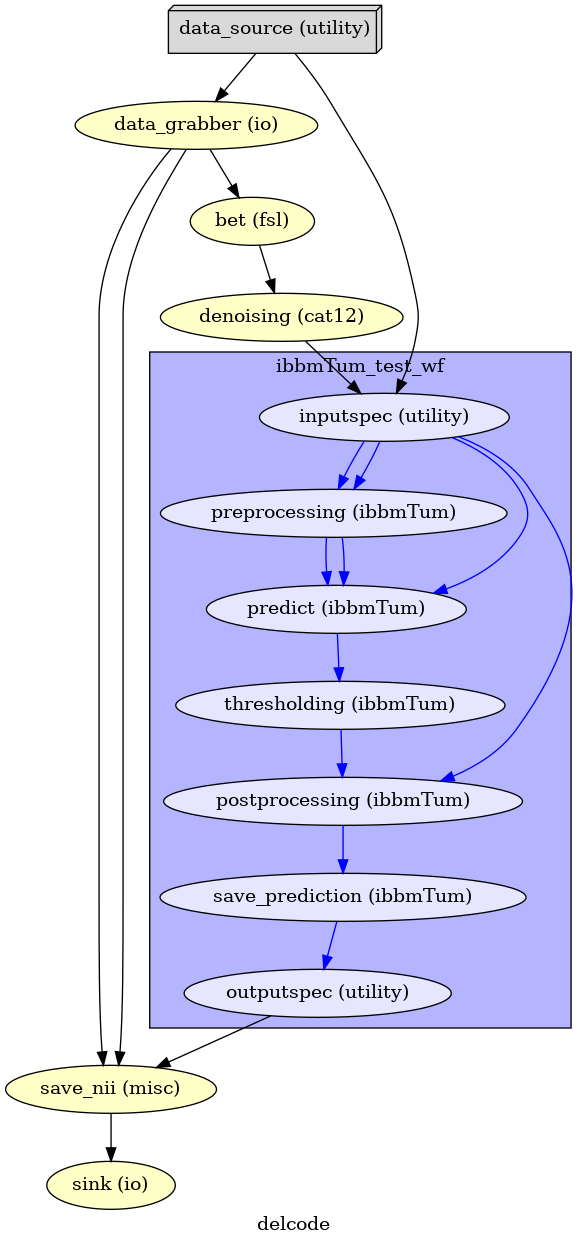

In [39]:
from IPython.display import Image
delcode.write_graph(graph2use='colored', dotfilename='./imgs/delcode.dot')
Image('./imgs/delcode.png')

In [44]:
#plugin_args = {'n_procs': 10}
#delcode.run(plugin='MultiProc', plugin_args=plugin_args)
delcode.run()

210925-18:13:17,89 nipype.workflow INFO:
	 Workflow delcode settings: ['check', 'execution', 'logging', 'monitoring']
210925-18:13:17,961 nipype.workflow INFO:
	 Running serially.
210925-18:13:17,964 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_b38c31704/data_grabber".
210925-18:13:18,489 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-18:13:18,688 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-18:13:18,690 nipype.workflow INFO:
	 [Node] Setting-up "delcode.bet" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_b38c31704/bet".
210925-18:13:20,494 nipype.workflow INFO:
	 [Node] Running "bet" ("nipype.interfaces.fsl.preprocess.B

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-18:22:19,615 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-18:22:19,617 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_b38c31704/sink".
210925-18:22:19,928 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-18:22:20,190 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-18:22:20,192 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_b362efb8f/data_grabber".
210925-18:22:20,879 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-18:22:21,242 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-18:22:21,244 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-18:30:03,514 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-18:30:03,515 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_b362efb8f/sink".
210925-18:30:03,756 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-18:30:04,34 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-18:30:04,35 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_f3a9124c6/data_grabber".
210925-18:30:04,735 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-18:30:04,930 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-18:30:04,932 nipyp

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-18:38:39,522 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-18:38:39,523 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_f3a9124c6/sink".
210925-18:38:39,734 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-18:38:40,155 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-18:38:40,157 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_60a8dd7f5/data_grabber".
210925-18:38:41,22 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-18:38:41,287 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-18:38:41,289 nipy

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-18:46:53,17 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-18:46:53,19 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_60a8dd7f5/sink".
210925-18:46:53,863 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-18:46:54,133 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-18:46:54,135 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_3037ab030/data_grabber".
210925-18:46:55,119 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-18:46:55,296 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-18:46:55,298 nipyp

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-18:54:45,625 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-18:54:45,627 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_3037ab030/sink".
210925-18:54:45,784 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-18:54:46,56 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-18:54:46,58 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_172ff8939/data_grabber".
210925-18:54:46,744 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-18:54:46,878 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-18:54:46,880 nipyp

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-18:55:16,57 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-18:55:16,59 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_172ff8939/sink".
210925-18:55:16,271 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-18:55:16,451 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-18:55:16,452 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_f2a767eaa/data_grabber".
210925-18:55:17,203 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-18:55:17,496 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-18:55:17,498 nipyp

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-19:02:07,254 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-19:02:07,256 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_f2a767eaa/sink".
210925-19:02:07,390 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-19:02:07,524 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-19:02:07,525 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_ae818e1d7/data_grabber".
210925-19:02:08,19 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-19:02:08,148 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-19:02:08,150 nipy

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-19:09:05,280 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-19:09:05,282 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_ae818e1d7/sink".
210925-19:09:05,415 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-19:09:05,548 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-19:09:05,550 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_60087d2cb/data_grabber".
210925-19:09:06,44 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-19:09:06,174 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-19:09:06,176 nipy

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-19:15:58,281 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-19:15:58,283 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_60087d2cb/sink".
210925-19:15:58,417 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-19:15:58,549 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-19:15:58,551 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_5c4e89915/data_grabber".
210925-19:15:59,41 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-19:15:59,170 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-19:15:59,172 nipy

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-19:22:47,757 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-19:22:47,759 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_5c4e89915/sink".
210925-19:22:47,892 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-19:22:48,24 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-19:22:48,26 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_9dc5af14f/data_grabber".
210925-19:22:48,514 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-19:22:48,643 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-19:22:48,645 nipyp

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-19:29:54,567 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-19:29:54,569 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_9dc5af14f/sink".
210925-19:29:54,703 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-19:29:54,835 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-19:29:54,837 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_59d4008a7/data_grabber".
210925-19:29:55,330 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-19:29:55,460 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-19:29:55,461 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-19:30:16,838 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-19:30:16,840 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_59d4008a7/sink".
210925-19:30:16,971 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-19:30:17,105 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-19:30:17,107 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_144014f58/data_grabber".
210925-19:30:17,598 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-19:30:17,728 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-19:30:17,730 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-19:37:33,559 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-19:37:33,561 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_144014f58/sink".
210925-19:37:33,694 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-19:37:33,827 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-19:37:33,829 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_96357826f/data_grabber".
210925-19:37:34,319 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-19:37:34,452 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-19:37:34,454 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-19:44:34,374 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-19:44:34,375 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_96357826f/sink".
210925-19:44:34,508 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-19:44:34,640 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-19:44:34,642 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_13c6322ae/data_grabber".
210925-19:44:35,135 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-19:44:35,266 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-19:44:35,268 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-19:51:37,150 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-19:51:37,152 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_13c6322ae/sink".
210925-19:51:37,283 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-19:51:37,415 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-19:51:37,417 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_d23ebb73d/data_grabber".
210925-19:51:37,906 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-19:51:38,35 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-19:51:38,37 nipyp

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-19:58:38,88 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-19:58:38,90 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_d23ebb73d/sink".
210925-19:58:38,223 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-19:58:38,355 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-19:58:38,357 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_4a1bb1546/data_grabber".
210925-19:58:38,857 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-19:58:38,986 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-19:58:38,987 nipyp

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-20:06:06,515 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-20:06:06,517 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_4a1bb1546/sink".
210925-20:06:06,675 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-20:06:06,955 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-20:06:06,957 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_4798dd03c/data_grabber".
210925-20:06:07,622 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-20:06:07,791 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-20:06:07,793 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-20:13:31,68 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-20:13:31,70 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_4798dd03c/sink".
210925-20:13:31,226 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-20:13:31,417 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-20:13:31,419 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_9446d0c1d/data_grabber".
210925-20:13:31,985 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-20:13:32,175 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-20:13:32,177 nipyp

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-20:21:05,604 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-20:21:05,606 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_13b9c5985/sink".
210925-20:21:05,792 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-20:21:05,962 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-20:21:05,964 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_8740df278/data_grabber".
210925-20:21:06,97 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-20:21:06,295 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-20:21:06,297 nipy

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-20:28:30,909 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-20:28:30,911 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_8740df278/sink".
210925-20:28:31,61 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-20:28:31,194 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-20:28:31,196 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_c276f7df7/data_grabber".
210925-20:28:31,328 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-20:28:31,458 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-20:28:31,459 nipy

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-20:36:03,753 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-20:36:03,755 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_c276f7df7/sink".
210925-20:36:03,888 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-20:36:04,36 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-20:36:04,38 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_bc177df98/data_grabber".
210925-20:36:04,185 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-20:36:04,315 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-20:36:04,316 nipyp

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-20:43:24,209 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-20:43:24,211 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_bc177df98/sink".
210925-20:43:24,352 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-20:43:24,484 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-20:43:24,486 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_0a8d02f2b/data_grabber".
210925-20:43:24,618 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-20:43:24,766 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-20:43:24,768 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-20:51:00,230 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-20:51:00,232 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_0a8d02f2b/sink".
210925-20:51:00,519 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-20:51:00,651 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-20:51:00,653 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_74c764c7b/data_grabber".
210925-20:51:00,785 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-20:51:00,920 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-20:51:00,922 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-20:58:01,376 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-20:58:01,378 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_74c764c7b/sink".
210925-20:58:01,512 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-20:58:01,645 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-20:58:01,647 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_3d0f5ce2b/data_grabber".
210925-20:58:01,779 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-20:58:01,909 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-20:58:01,911 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-21:05:00,452 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-21:05:00,454 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_3d0f5ce2b/sink".
210925-21:05:00,588 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-21:05:00,720 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-21:05:00,722 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_72e485c23/data_grabber".
210925-21:05:00,853 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-21:05:00,987 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-21:05:00,988 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-21:12:13,832 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-21:12:13,833 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_72e485c23/sink".
210925-21:12:13,967 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-21:12:14,103 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-21:12:14,104 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_34f06b217/data_grabber".
210925-21:12:14,235 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-21:12:14,364 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-21:12:14,366 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-21:19:33,331 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-21:19:33,333 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_34f06b217/sink".
210925-21:19:33,467 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-21:19:33,600 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-21:19:33,602 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_fd225d1ef/data_grabber".
210925-21:19:33,733 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-21:19:33,862 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-21:19:33,864 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-21:26:42,722 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-21:26:42,724 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_fd225d1ef/sink".
210925-21:26:42,857 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-21:26:42,989 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-21:26:42,991 nipype.workflow INFO:
	 [Node] Setting-up "delcode.data_grabber" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_01dc83c85/data_grabber".
210925-21:26:43,122 nipype.workflow INFO:
	 [Node] Running "data_grabber" ("nipype.interfaces.io.DataGrabber")
210925-21:26:43,251 nipype.workflow INFO:
	 [Node] Finished "delcode.data_grabber".
210925-21:26:43,253 nip

sizeof_hdr should be 540; set sizeof_hdr to 540


210925-21:33:58,528 nipype.workflow INFO:
	 [Node] Finished "delcode.save_nii".
210925-21:33:58,530 nipype.workflow INFO:
	 [Node] Setting-up "delcode.sink" in "/data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/train_wf/delcode/_sub-id_01dc83c85/sink".
210925-21:33:58,665 nipype.workflow INFO:
	 [Node] Running "sink" ("nipype.interfaces.io.DataSink")
210925-21:33:58,798 nipype.workflow INFO:
	 [Node] Finished "delcode.sink".
210925-21:33:58,799 nipype.workflow INFO:
	 ***********************************
210925-21:33:58,800 nipype.workflow ERROR:
	 could not run node: delcode.bet.a11
210925-21:33:58,801 nipype.workflow INFO:
	 crashfile: /data/ag-wirth/Imaging/04_Projects/DELCODE_DZNE/01_MRI_computations/2021_WMH_seg_DELCODE/MRI_data/nipype_pipeline/WMHpypes/examples/crash-20210925-201403-dellorcoa-bet.a11-a3cc557e-2f3a-4a45-b1ca-5184134b5e59.pklz
210925-21:33:58,802 nipype.workflow INFO:
	 ***************

RuntimeError: Workflow did not execute cleanly. Check log for details